In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle
import glob
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,6)})

In [5]:
import tensorflow as tf
import tensorflow.keras as tk
import tensorflow.keras.layers as tkl

In [6]:
from drl.trading_model import MarketEnvironment, Observation
from drl.investor_model_cnn import new_actor, new_critic
from drl.project_utils import plot_behaviour, validate, validate_samples
from drl.project_utils import qfun_from_rewards, trading_trajectory

In [7]:
import numpy as np
np.random.seed(17)

---

# Deep Reinforcement Learning

## Introducing the environment
The first of the two fundamental concepts of DRL is the environment

#### ```Environment``` and ```EnvironmentFactory```

In [8]:
from drl.trading_model import MarketEnvironment, EnvironmentFactory

In [9]:
# One million in cash and 100'000 worth of every available stock
portfolio= [1e6] + 10 * [1e5]
print(portfolio)

[1000000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0]


Our enviroments are all created from files containing some precomputed market history. All the files must contain data for the same securities and sentiment history.

In [10]:
factory = EnvironmentFactory(pattern="synthetic_eod/*.pkl", 
                             duration=1024, 
                             n_hist=128, 
                             portfolio=portfolio, 
                             return_scale=100, 
                             weight_scale=10, 
                             fee = 2.5e-3)

In our market environment, 10 different securities are being traded.

In [11]:
tickers = factory.tickers()
print(tickers[0])

['TYPL', 'WLUV', 'PHTT', 'LTRD', 'VDYQ', 'QYEV', 'XFXC', 'OENB', 'UGBP', 'ONAK']


Let's look at the first symbol. In the two files, we have a total of 20 different market runs for the same conditions. They expectedly lead to similar price charts. That's the beauty of synthetic data, it allows to measure a particular situation more than once. Reality doesn't come with that luxury.

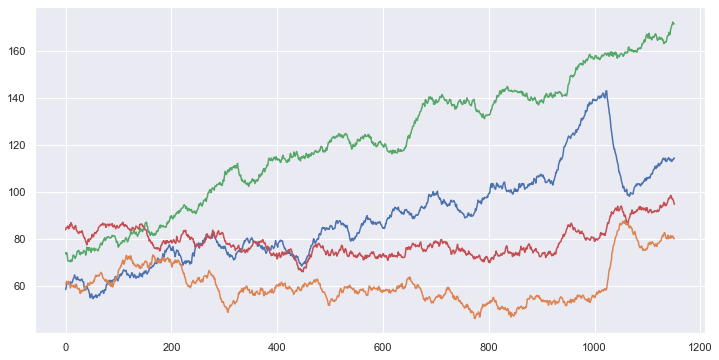

In [12]:
plt.plot(factory.prices_for(tickers[0][0], index=0));
plt.plot(factory.prices_for(tickers[7][0], index=7) + 10);
plt.plot(factory.prices_for(tickers[11][0], index=11) + 20);
plt.plot(factory.prices_for(tickers[17][0], index=17) + 30);

OpenAI's environment description demands a ```reset()``` function. We don't have that. We rather create a completely new environment, which is semantically equivalent from an algorithmic point of view. Note that the actual prices may differ, as the factory chooses randomly from the various datasets in the files.

In [13]:
env = factory.new_env()

hist = env.state()[0]
hist.shape, hist[0, 1, 0, 0]

((1, 128, 10, 1), 0.28295365)

#### Take one (rebalance) step in time and observe next state

In [14]:
new_weights = np.array(portfolio) / 2e6
observation = env.step(new_weights)

```observation.s``` is the previous state

In [15]:
observation.s[0].shape, observation.s[1]

((128, 10),
 array([0.5 , 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       dtype=float32))

```observation.a``` is the action that we have taken

In [16]:
observation.a

array([0.5 , 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
      dtype=float32)

```observation.r``` is the immediate reward - the single-day log return of the portfolio after the action.

In [17]:
observation.r

0.0004361466284393575

...and ```observation.s1``` is the new state after the rebalance action and subtraction of the fees.

In [18]:
observation.s1[0].shape, observation.s1[1]

((128, 10), array([0.5       , 0.05042868, 0.04937612, 0.04963499, 0.05031015,
        0.05      , 0.04967525, 0.05075718, 0.04954105, 0.05088116,
        0.04983165], dtype=float32))

Note that while the ```observation``` object contains the true values of the market history and the portfolio weights the ```state()``` function returns those values scaled up for computational efficiency.

---

## Introducing the actor

The actor is the second fundamental concept of DRL. In our case, it's a neural network consisting of a convolutional layer and a configurable number of dense layers. The actor takes as input the current market history and the current portfolio including the cash position and returns a list of new portfolio weights, which represents the action that is then to be taken on the environment. See [Supervised_Learning.ipynb](Supervised_Learning.ipynb) to learn about the details of such a neural network.

In [19]:
from drl.project_utils import trading_trajectory
from drl.investor_model_cnn import new_actor

In [20]:
actor = new_actor(
    n_market=10, 
    n_history=128, 
    n_filters=16, 
    n_portfolio=11, 
    layers=[64, 32, 16]
)

In [21]:
state = env.state()

#### Actors act on the state

In [22]:
actor(state).numpy()

array([[0.04413748, 0.09326288, 0.02393757, 0.1448494 , 0.08042034,
        0.14202902, 0.1626898 , 0.1126458 , 0.08308396, 0.04583259,
        0.06711111]], dtype=float32)

The bar plot depicts the actor's recommendation. Since the actor hasn't learned anything yet, these portfolio weights are absolute random.

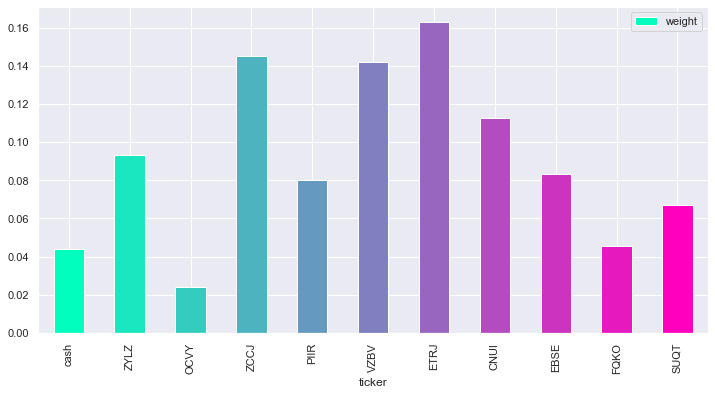

In [23]:
dataset = 7 # just any out of the 20 datasets
env = factory.new_env(dataset) 
df = pd.DataFrame(zip(['cash'] + tickers[dataset], actor(state).numpy()[0]), 
                  columns=["ticker", "weight"])
df.set_index('ticker');
my_colors = [(x/10.0, 1-x/10.0, 0.75) for x in range(len(df))] 
df.plot.bar(x='ticker', y='weight', color=my_colors);

#### Introducing *trajectories*
A trajectory $\tau$ is a sequence of SARS (state-action-return-state) tuples, produced by repeatedly performing the suggested actions of an actor. Each state consists of market history and portfolio weights. In the context of reinforcement learning, trajectories are often also called *episodes*. Depending on the context, I use one or the other interchangeably.

$$
\tau_i = (mh_i, pw_i, a_i, r_i, mh_{i+1}, pw_{i+1})
$$

With $mh$ being the observed market history up to the current time, $pw$ being the current portfolio weights, $a$ being the actions taken from there, and finally $r$ being the returns collected on during the episode. Note, that the state of the environment at time $t$ is given by the pair $(mh_t, pw_t)$.


To enforce the exploration of unknown territory, all the actions suggested by the actor undergo some randomization. The characteristics of the *noise* that we use for that purpose are explained in more detail in [Trading_Sine_Waves.ipynb](Trading_Sine_Waves.ipynb).

In [24]:
N_E = 20      # Number of episodes (trajectories)
NOISE_LEVEL = 2.0
N_STEPS = 1023 # number of steps for each episode
N_HOLD = 1

In [25]:
def uniform_noise(actions, kappa):
    """
    randomize the given actions
    params
    """
    assert(kappa >= 0)
    a1 = (1+kappa)**((np.random.random(actions.shape)-.5)) * actions
    return (a1.T/np.sum(a1, axis=-1)).T

In [26]:
i = 0
env = factory.new_env()

# S(t)     A        R      S(t+1)
mh, pw, actions, returns, mh1, pw1 = trading_trajectory(
    actor, env, 
    lambda a, params: uniform_noise(a, NOISE_LEVEL * (N_E - i) /N_E), 
    duration = N_STEPS//N_HOLD, hold=N_HOLD)

The trailing dimension in the shape of the market history is there to satisfy the convolutional layer's input's third dimension *depth* or *color*. 

In [27]:
mh.shape

(1023, 128, 10, 1)

---
## Introducing the algorithm: DDPG
#### Deep Deterministic Policy Gradient

Timothy Lillicrap of David Silver's team at Google Deepmind published a paper called *Continuous Control with Deep Reinforcement Learning*, describing an algorithm suitable for training robots to control their various actuators. What's actuators control signals for robots is portfolio weights for us.

The original Deep Deterministic Policy Gradient algorithm was defined like below

---

Using the discount factor $\gamma$ and the target learning rate $\tau$<br/>
Randomly initialize the primary networks</br>
Initialize the target networks $\mu^\prime$ and $Q^\prime$ with the weights of the primary network $\theta^\prime \leftarrow \theta$, $\phi^\prime \leftarrow \phi$</br>
Initialize replay buffer $R$</br>
**for** episode = 1, $N_E$ **do**</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Initialize random process $\mathcal N$ for action exploration</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Receive initial observation state $s_1$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**for** t=1, L (length of each episode), **do**<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Select action $a_t = \mu(s_t|\theta) + \mathcal{N}_t$ according to the current policy and exploration noise<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Execute action $a_t$ and observe reward $r_t$ and new state $s_{t+1}$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Store transition $(s_t, a_t, r_t, s_{t+1})$ in $R$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Sample a random minibatch of $N_B$ transitions $(s_i, a_i, r_i, s_{i+1})$ from $R$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Calculate the $Q$-targets: 

$$
y_i = r_i + \gamma Q^\prime(s_{i+1}, \mu^\prime(s_{i+1}|\theta^\prime)|\phi^\prime)
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Update the primary critic by minimizing the loss: 

$$
L = \frac{1}{N_B}\sum_i(y_i-Q(s_i, a_i|\phi))^2
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Update the actor policy using the sampled policy gradient:

$$
\nabla_\theta J \approx \frac{1}{N_B}\sum_{i=1}^{N_B}\nabla_a Q(s, a|\phi)|_{s=s_i, a=\mu(s_i)}
\nabla_\theta \mu(s|\theta)|_{s_i}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Update the target networks: 

$$
\theta^\prime \leftarrow \tau \theta + (1-\tau) \theta^\prime
$$

$$
\phi^\prime \leftarrow \tau \phi + (1-\tau) \phi^\prime
$$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**end for**<br/>
**end for**<br/>

---

The authors took a single sample in each iteration utilizing a replay buffer for efficiency. That's all good and important for continuous control use cases for which the algorithm has been developed. The portfolio problem is much less sensitive to straying from the perfect trajectory because even with a bad history of investments one can still learn well from new experience. That's completely different from robotics. When these guys are down on their backs they'll have to spend significant effort before they can continue learning to walk.

We'll sample a complete trading episode of some hundreds of rebalancing actions and continue our learning process from there without a replay buffer. We also initialize the environment stochastically to reduce self-induced bias. 

#### The story behind the algorithm

DDPG is a variant of the *actor-critic* family of algorithms. In fact that's why we called our neural network above an *actor*. Elsewhere, these neural networks are called *policy*, that's where the *P* comes from in DDPG. 

These *actor-critic* algorithms employ the idea that there is an actor or *policy* that determines the next step. That's the next re-balancing weights in our case. Then, there is another neural network that looks at the current state and the actor's recommendation and returns a single number - the so-called $Q$-Value of that state action pair. This is the *critic*, it kind-of tells the actor whether the action is good or not.

The reinforcement learning algorithm is designed to consider that $Q$-function an approximation for the *real* $Q$-function. The *real* $Q$-function is the theoretical function that always tells the maximum value that can be obtained from the given state, taking the given action. If we had that kind of function in real life, we could calculate its value for every decision that we have to take and simply take the option with the highest $Q$ value. 

Alas, that *real* $Q$-function can only be explicitely formulated for very few problems. But we can try to iteratatively adjust any given parameterized function (a neural network, obviously) to approximate the *true* $Q$ function better and better. 

In *actor-critic* algorithms we optimize these two neural networks iteratively one by one, and eventually - if everything works well - the actor learns to suggest the best re-balancing action at any point in time.

In our experiment, repeatedly perform the following steps

#### 1) Trade for a given an episode using the primary actor
Record all states and actions - that's our trajectory.

#### 2) Optimize the primary $Q$-function (the critic) on that trajectory
It's this so-called Bellmann update that makes the $Q$ functions *see the future*
    
#### 3) Optimize the primary policy (the actor), such that it maximizes the $Q$ function
This step is actually what we want most: Make the policy better each step!

#### 4) Update the target actor and target critic
Since we have two pairs of neural network for stability reasons, we need to transfer the learned behaviour from the primary networks to the target networks.

In [28]:
A_LAYERS = [128, 64, 16]
C_LAYERS = [128, 64, 16]
N_FILTERS = 32

N_M = 10
N_P = 11
N_H = 16
FEE = 2.5e-3

N_E = 30 # number of episodes for training
NOISE_LEVEL = 4.0
INITIAL_PORTFOLIO = [1e6] + [1e5] * 10
N_STEPS = 1023 # number of steps for each episode
N_HOLD = 4
N_UPDATE_CRITIC = 16
N_UPDATE_ACTOR = 1

RETURN_SCALE=100
WEIGHT_SCALE=.1
TARGET_SCALE=10

GAMMA = 0.999

TAU = 0.1

#### DDPG uses two actor-critic pairs

In [29]:
primary_critic = new_critic(N_M, N_H, N_FILTERS, n_portfolio=N_P, 
                            layers=C_LAYERS, n_kernel=N_H)
pc_loss = tf.keras.losses.mean_squared_error
pc_optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
primary_critic.compile(loss = pc_loss, optimizer=pc_optimizer)

primary_actor = new_actor(N_M, N_H, N_FILTERS, N_P, A_LAYERS, n_kernel=N_H)
pa_optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)

target_critic = new_critic(N_M, N_H, N_FILTERS, N_P, C_LAYERS, n_kernel=N_H)
target_critic.set_weights(primary_critic.get_weights())

target_actor = new_actor(N_M, N_H, N_FILTERS, N_P, A_LAYERS, n_kernel=N_H)
target_actor.set_weights(primary_actor.get_weights())

### Train!

In [30]:
factory = EnvironmentFactory(pattern="synthetic_eod/*.pkl", 
                             duration=1024, 
                             n_hist=N_H, 
                             portfolio=portfolio, 
                             return_scale=100, 
                             weight_scale=10, 
                             fee = FEE)

In [31]:
num_vali = 3
num_train = len(factory.data) - num_vali
num_train

17

In [41]:
rets = {i+1: [] for i in range(num_vali)}
for i in range(N_E):

    dataset = i % num_train
    
    env = factory.new_env(i % num_train)
    
    #
    #       Sample an entire episode
    #       Use a noise level that decreases over time
    #
    mh, pw, actions, returns, mh1, pw1 = trading_trajectory(
        primary_actor, env, 
        lambda a, params: uniform_noise(a, NOISE_LEVEL * (N_E - i) /N_E), 
        duration = N_STEPS//N_HOLD, hold=N_HOLD)    
    
    #
    #      Train the critic on the Bellmann target
    #
    Q = target_critic([mh1, pw1, target_actor([mh1, pw1])])
    targets = TARGET_SCALE * returns + GAMMA * Q

    h = primary_critic.fit(x=[mh, pw, actions], 
                           y=targets, epochs=N_UPDATE_CRITIC, 
                           verbose=False)

    #
    #      Update the actor with the policy gradient
    #
    for _ in range(N_UPDATE_ACTOR):
        with tf.GradientTape() as tape:
            actions = primary_actor([mh, pw])
            
            # the optimizer needs a loss to minimize 
            loss = -tf.reduce_mean(primary_critic([mh, pw, actions]))

            theta = primary_actor.trainable_variables
            gradients = tape.gradient(loss, theta)
            pa_optimizer.apply_gradients(zip(gradients, theta));

    #
    #      Update the target network
    #
    weight_pairs = zip(target_actor.get_weights(), primary_actor.get_weights())
    new_actor_weights = [taw * ( 1 - TAU ) + paw * TAU for taw, paw in weight_pairs]
    target_actor.set_weights(new_actor_weights)

    weight_pairs = zip(target_critic.get_weights(), primary_critic.get_weights())
    new_critic_weights = [tcw * ( 1 - TAU ) + pcw * TAU for tcw, pcw in weight_pairs]
    target_critic.set_weights(new_critic_weights)
     
    print("Episode: %s" % (i+1))
    env = factory.new_env(dataset) 
    ret, fees = validate(primary_actor, env, duration=256, start_at=0)
    print("Training Return: %s, fees paid: %s" % (ret, fees))
    
    for v in range(len(factory.data)-num_train): # these haven't been used for training
        env = factory.new_env(num_train+v) 
        ret, fees = validate(primary_actor, env, duration=256, start_at=0)
        rets[v+1].append(ret)
        print("Eval Return: %s, fees paid: %s" % (ret, fees))
    

Episode: 1
Training Return: 0.7171490625, fees paid: 20381.26
Eval Return: 0.7171490625, fees paid: 20381.26
Eval Return: 0.7787105625, fees paid: 15017.07
Eval Return: 1.074818625, fees paid: 12391.3
Episode: 2
Training Return: 1.140644375, fees paid: 11396.36
Eval Return: 0.717267875, fees paid: 20228.6
Eval Return: 0.778727625, fees paid: 14931.95
Eval Return: 1.074862375, fees paid: 12346.75


KeyboardInterrupt: 

The ever decreasing fees look suspicious. Our algo eventually concluded that the best thing to do in this market is stick to one stock and hold it forever.

The charts for the returns on the evaluation set confirm the finding. After 13 episodes, the algorithm stopped changing anything. The returns on the validation set reflect the buy-and-hold gains for the respective equities chosen on here.

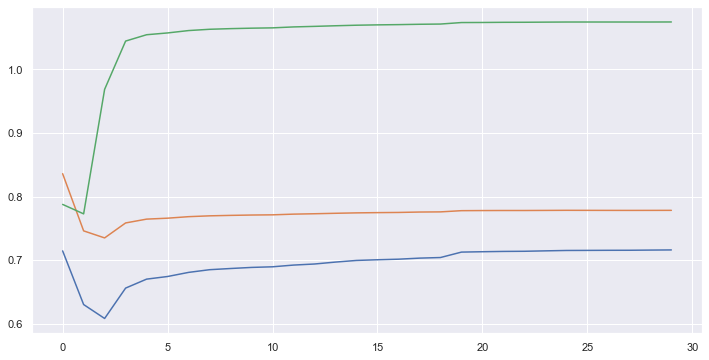

In [33]:
plt.plot(rets[1]);
plt.plot(rets[2]);
plt.plot(rets[3]);

In [34]:
env = factory.new_env(num_train) 

In [35]:
mh, pw = env.state()

In [36]:
action = primary_actor([mh, pw]).numpy()[0]

In [37]:
action

array([8.4446650e-04, 2.8932181e-03, 1.0038015e-03, 9.6244442e-01,
       8.9024665e-04, 1.2726578e-02, 4.9081570e-03, 2.6171794e-03,
       9.3120604e-04, 5.1069572e-03, 5.6338236e-03], dtype=float32)

We can see that the algorithm has collapsed on a single equity, holding it forever after the original purchase.

In [38]:
def plot_behaviour(actor, env, duration, position):
    """
    duration: duration in time steps
    positions: which of the actions to display
    """
    from copy import deepcopy
    env = deepcopy(env)
    wealth = []
    security = []
    holding = []
    cash = []

    mh, pw = env.state()
    for i in range(duration):
        action = actor([mh, pw]).numpy()[0]
        obs = env.step(action)

        mh, pw = env.state()

        wealth.append(env.wealth() / 1e7)
        security.append(obs.s[0][-1][position])
        holding.append(action[position])
        cash.append(action[0])

    plt.plot(np.array(security).cumsum())
    plt.plot(cash)
    plt.plot(holding)
    plt.plot(wealth)


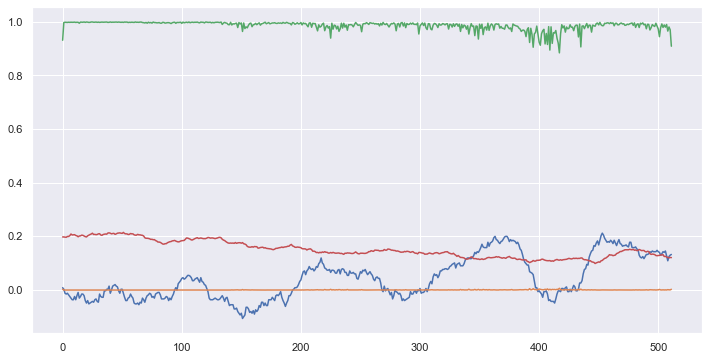

In [43]:
plot_behaviour(primary_actor, env, 512, 3)

This is the performance on one of the validation sets

- Green: The single holding that our actor resorted to.
- Red: The wealth over time
- Blue: the single equity's accumulated price change 
- Orange: the cash position

---
## Conclusion
Although the algorithm did a surprisingly good job on the toy-problem of trading sine waves, it never managed to deal with the noise and unpredictability of earnings surprises that determine the synthetic market datasets. The small benefit that might come from spotting periods of momentum behaviour is outweighed by the transaction costs trying. Thus the algorithm does what my mother always said: Buy one stock that you believe in and keep your fingers off your portfolio until you need the money. 

While that is not really a surprise, it's still disappointing. What could be do to improve the result?

#### Use an LSTM rather than a convolutional layer
An LSTM would be able to exploit relationships between the stocks. In our setup, there are no such relationships apart from the common influence of sector and geography sentiments. And these would have been expoited by the conv-net, too, if that had helped. 

#### Provide a richer market model with more semantics
The only thing that our algorithm could've possibly exploited is the inertia, that is exposed by the additional momentum - the overshooting - of the stocks. This effect shows in slightly longer upturns and downturns. With the sine wave toy problem this phenomenon was so strong that the algorithm managed to eploit it. Here, the effect is just too small and unreliable. So, if we had more semantics like e.g. a leader/follower pattern between stocks, then that might be somewhat exploitable. 

#### Add hand-crafted features
Also an interesting option. Maybe e.g. some moving averages can act as hints for the expected perceived value, or intrinsic value of a stock. Although the algorithm should have found exactly that by itself, maybe it didn't because of the noise.

#### Provide the algorithm the EPV as additional input
This is possibly one of the best options. The algorithm would have a means to anticipate the other traders actions, if it *sees* the EPV or *intrinsic* value of the stock. It would recognize undervalued stocks and would even be able to better estimate the influence of momentum. 

